# MSc in Data Analytics
# Sentiment Analysis Assignment - STEP 2

Assessment Task
Students are advised to review and adhere to the submission requirements documented after the assessment task.  
In this continuous assessment, You are required to identify and carry out an analysis of a large dataset gleaned from the twitter API. Instructions for accessing the data can be found here  
https://datascienceparichay.com/article/get-data-from-twitter-api-in-python-step-by-step-guide/  
https://www.toptal.com/apache/apache-spark-streaming-twitter  
OR You may use the data held here:  
https://archive.org/details/twitterstream?sort=-publicdate  
You must collect at least 1 year's tweets on a topic, this data should be stored as requested below, and you are then required to analyse any change sentiment that occurs over the time period that you have selected.  
Following your analysis, you are then required to make a time series forecast of the sentiment at 1 week, 1 month and 3 months going forward. This forecast must be displayed as a dynamic dashboard.   

### Assignment
Topic: vaccine

this notebook will read the dataset containing only the tweeets related to vaccine.  
The dataset represent tweets from June 2020 until May 2021. **The dataset was downloaded from the link https://archive.org/details/twitterstream?sort=-publicdate**  


## Perform Sentiment Analysis

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
import pyspark.sql.functions as F

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM

import numpy as np
import pandas as pd

import json, os

In [3]:
# Create the Spark Context

spark = SparkSession \
    .builder \
    .appName("sba22243-sentiment") \
    .config("spark.sql.debug.maxToStringFields", 100) \
    .config("spark.mongodb.input.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config("spark.mongodb.output.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.2') \
    .getOrCreate()
sqlContext = spark._wrapped

### Read the tweets rady for processing from MongoDB

In [4]:
# Read tweets from MongoDB
df = sqlContext.read.format("mongo").option("uri", "mongodb://192.168.0.107/sba22243.vaccine").load()

In [5]:
df.show(5)

+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
|                 _id|          created_at|day| full_date|month|                text| timestamp_ms|year|
+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
|{646a9a4ee12bed28...|Tue Jun 09 13:01:...|  9|2020-06-09|    6|THE INJECTION FRA...|1591707677660|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:03:...|  9|2020-06-09|    6|Tests for Coronav...|1591707810659|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:36:...|  9|2020-06-09|    6|@EricTrump Not if...|1591709812659|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:38:...|  9|2020-06-09|    6|@gorygaming24601 ...|1591709885662|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:39:...|  9|2020-06-09|    6|Philippines Stude...|1591709982665|2020|
+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
only showing top 5 rows



In [6]:
# Convert spark dataframe into Pandas dataframe
pdf = df.toPandas()

In [7]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020


## Sentiment Analysis

In [8]:
# Load the Vader Lexicon
nltk.download(["vader_lexicon",
             "stopwords"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
analyzer = SentimentIntensityAnalyzer()

### Text Preprocessor

In [10]:
stp_english = stopwords.words('english')
# Make text preprocessor
def tweet_preprocessor(tweet_text):
    token_list = word_tokenize(tweet_text.lower())
    token_without_stop_words = [token for token in token_list if token not in stp_english]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in token_without_stop_words]

    final_tweet = " ".join(tokens_lemmatized)
    return final_tweet

In [11]:
pdf['text_filtered'] = pdf['text'].apply(lambda x: tweet_preprocessor(x))

### Polarity Extraction

In [12]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,text_filtered
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,injection fraud - 's vaccine catherine austin ...
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,test coronavirus vaccine need ingredient : hor...
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,@ erictrump father n't wake forced vaccine bla...
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,@ gorygaming24601 ... oh wait right forgot tak...
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,philippine student face distance learning covi...


In [13]:
pdf['sentiment_compound'] = pdf['text_filtered'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [14]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,text_filtered,sentiment_compound
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,injection fraud - 's vaccine catherine austin ...,-0.5859
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,test coronavirus vaccine need ingredient : hor...,0.0000
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,@ erictrump father n't wake forced vaccine bla...,0.3570
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,@ gorygaming24601 ... oh wait right forgot tak...,0.0000
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,philippine student face distance learning covi...,0.0000


In [15]:
pdf['sentiment'] = np.where(pdf['sentiment_compound'] >= 0.05, 'Positive', np.where((pdf['sentiment_compound'] > -0.05) & (pdf['sentiment_compound'] < 0.05), 'Neutral', 'Negative'))

In [16]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,text_filtered,sentiment_compound,sentiment
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,injection fraud - 's vaccine catherine austin ...,-0.5859,Negative
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,test coronavirus vaccine need ingredient : hor...,0.0000,Neutral
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,@ erictrump father n't wake forced vaccine bla...,0.3570,Positive
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,@ gorygaming24601 ... oh wait right forgot tak...,0.0000,Neutral
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,philippine student face distance learning covi...,0.0000,Neutral


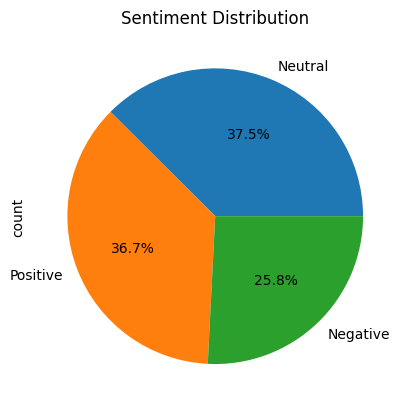

In [17]:
sentiment_counts = pdf['sentiment'].value_counts()
sentiment_counts.plot.pie(autopct='%.1f%%')
plt.title('Sentiment Distribution')
plt.show()

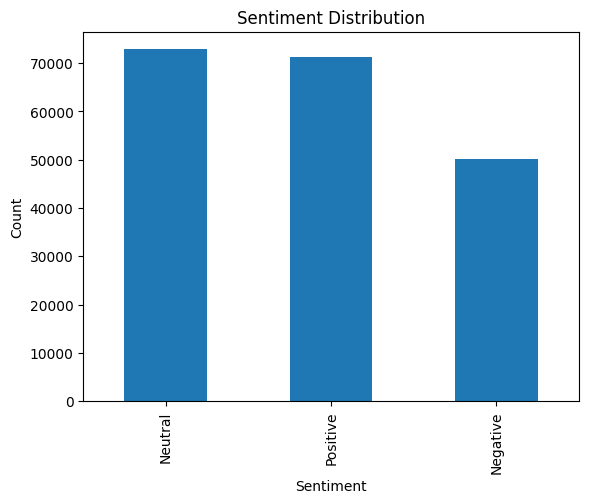

In [18]:
sentiment_counts = pdf['sentiment'].value_counts()
sentiment_counts.plot.bar()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

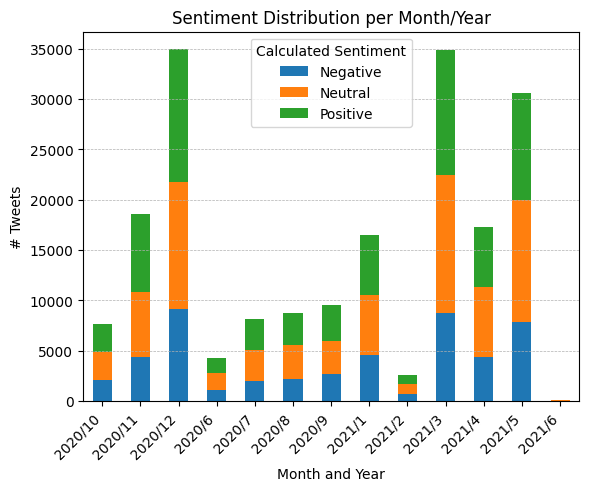

In [19]:
result_df = pdf.groupby(['year', 'month', 'sentiment'])['sentiment'].count().unstack('sentiment').fillna(0)
ax = result_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution per Month/Year')
plt.xlabel('Month and Year')
plt.ylabel('# Tweets')
plt.xticks(rotation=45, ha="right")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
xtick_labels = ['{}/{}'.format(int(year), int(month)) for year, month in result_df.index]
ax.set_xticklabels(xtick_labels)
ax.legend(title='Calculated Sentiment')
plt.show()

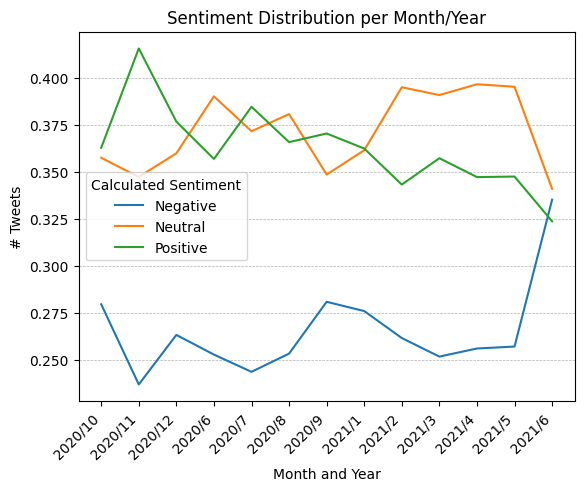

In [20]:
result_df = pdf.groupby(['year', 'month', 'sentiment'])['sentiment'].count().unstack('sentiment').fillna(0)
result_df = result_df.div(result_df.sum(axis=1), axis=0)
ax = result_df.plot(kind='line')
plt.title('Sentiment Distribution per Month/Year')
plt.xlabel('Month and Year')
plt.ylabel('# Tweets')
plt.xticks(rotation=45, ha="right")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.xaxis.set_major_locator(mtick.FixedLocator([0,1,2,3,4,5,6,7,8,9,10,11,12]))
xtick_labels = ['{}/{}'.format(int(year), int(month)) for year, month in result_df.index]
ax.set_xticklabels(xtick_labels)
ax.legend(title='Calculated Sentiment')
plt.show()

## Time Series Analysis

In [21]:
# data preparation for timeseries
time_series_df = pdf.copy(deep=True)
time_series_df.drop_duplicates(subset=['timestamp_ms'], keep='last', inplace=True)
time_series_df = time_series_df.loc[:, ['timestamp_ms', 'sentiment_compound']]

In [22]:
time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp_ms'], unit='ms')
time_series_df = time_series_df.sort_values(by='timestamp', ascending=True)
time_series_df.head()

C:\Users\Mara\AppData\Local\Temp\ipykernel_27376\1804642336.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp_ms'], unit='ms')


,timestamp_ms,sentiment_compound,timestamp
1512,1590995006659,0.0000,2020-06-01 07:04:18.688
1513,1590997328663,0.0000,2020-06-01 07:41:26.912
1514,1590998284666,-0.4019,2020-06-01 07:58:55.488
1515,1590999372665,0.5337,2020-06-01 08:16:24.064
1516,1591000848665,-0.1779,2020-06-01 08:40:25.856


In [23]:
time_series_df.set_index('timestamp', inplace=True)

In [24]:
time_series_df.head()

,timestamp_ms,sentiment_compound
timestamp,,
2020-06-01 07:04:18.688,1590995006659,0.0000
2020-06-01 07:41:26.912,1590997328663,0.0000
2020-06-01 07:58:55.488,1590998284666,-0.4019
2020-06-01 08:16:24.064,1590999372665,0.5337
2020-06-01 08:40:25.856,1591000848665,-0.1779


In [25]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red', linewidth = '0.7')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
    plt.show()

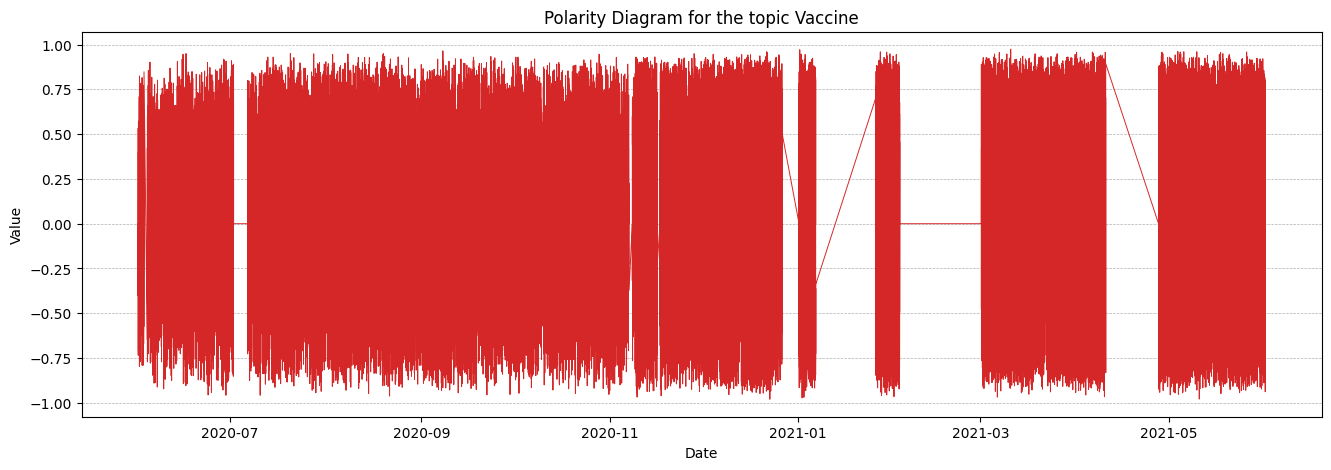

In [26]:
plot_df(x=time_series_df.index, y=time_series_df['sentiment_compound'], title='Polarity Diagram for the topic Vaccine')

In [27]:
# Resampling
time_series_df = time_series_df.resample('1d').mean()
time_series_df.dropna(how='all', inplace=True)
time_series_df.head()

,timestamp_ms,sentiment_compound
timestamp,,
2020-06-01,inf,0.049651
2020-06-02,inf,0.012126
2020-06-03,inf,0.131870
2020-06-04,inf,0.064276
2020-06-05,inf,0.036946


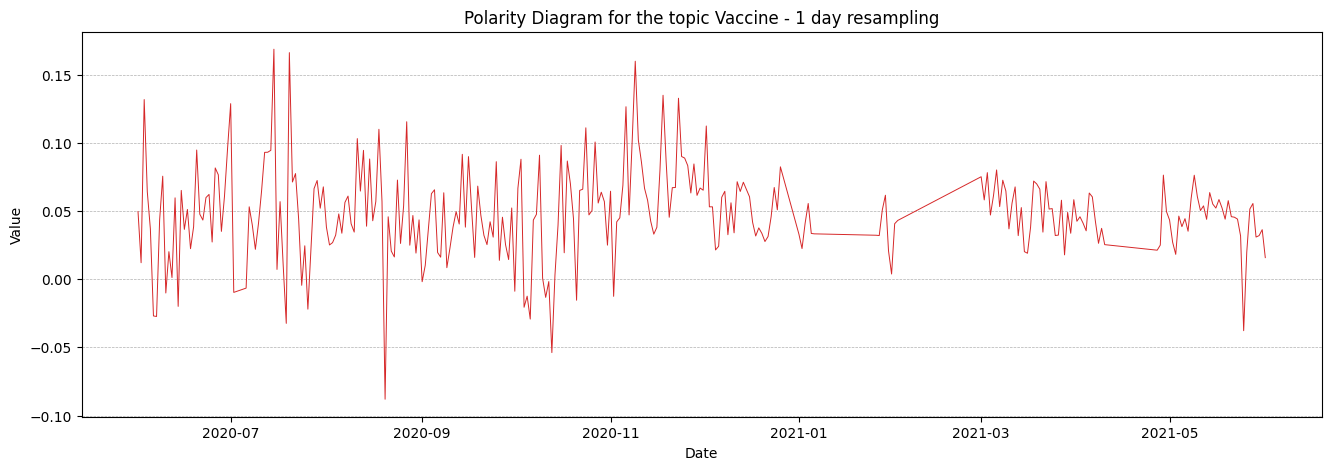

In [28]:
plot_df(x=time_series_df.index, y=time_series_df['sentiment_compound'], title='Polarity Diagram for the topic Vaccine - 1 day resampling')

In [29]:
# add +1 to sentiment_compound
time_series_df['sentiment_compound'] = time_series_df['sentiment_compound'] + 1

### Autocorrelation and Partial Autocorrelation

C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


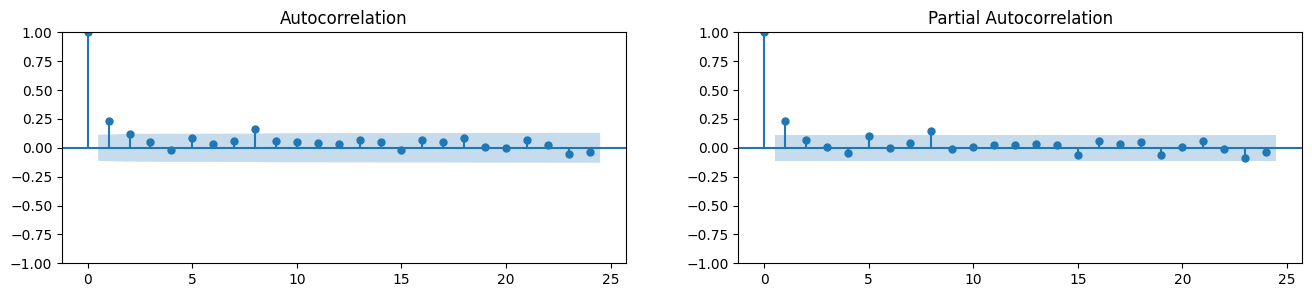

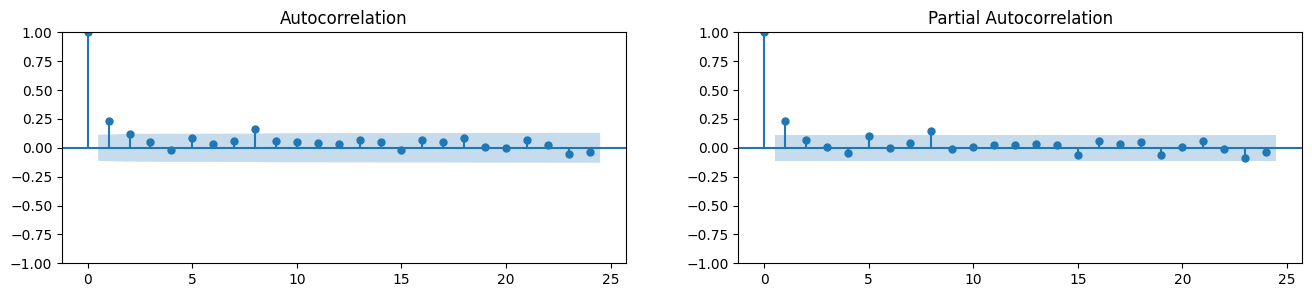

In [30]:
values = time_series_df['sentiment_compound'].tolist()

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(values, lags=24, ax=axes[0])
plot_pacf(values, lags=24, ax=axes[1])

### Decomposition 

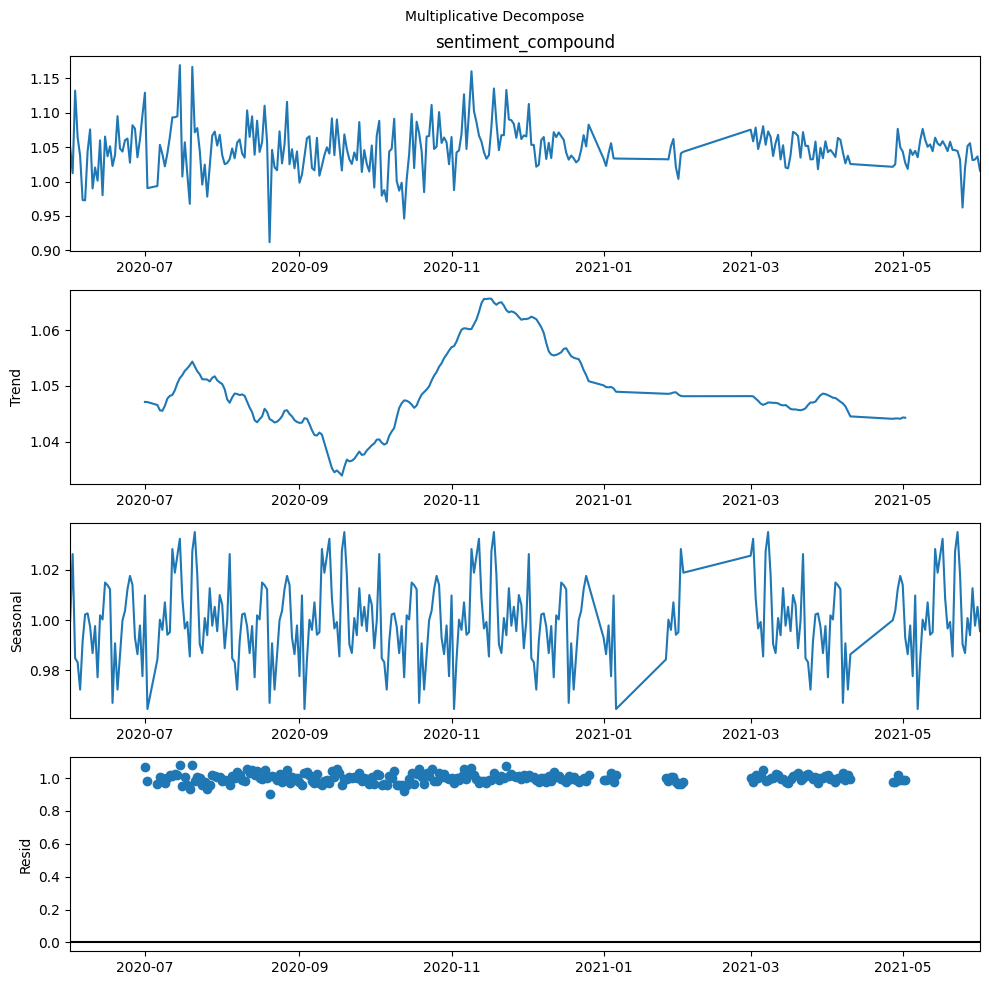

In [31]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(time_series_df['sentiment_compound'], model='multiplicative', period=60)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
plt.tight_layout()
plt.show()

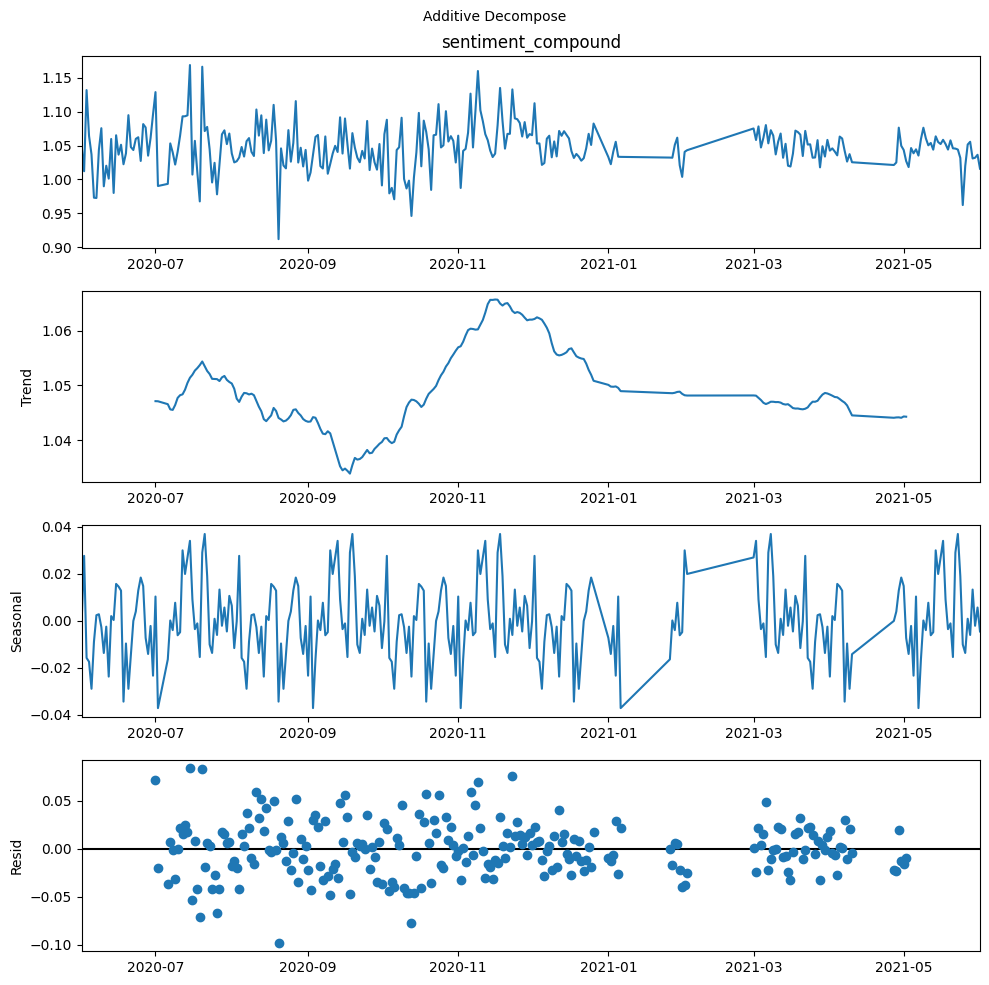

In [32]:
# Additive Decomposition
result_add = seasonal_decompose(time_series_df['sentiment_compound'], model='additive', period=60)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.tight_layout()
plt.show()

### Stationary and Non-Stationary Time Series

Using ADF and KPSS methots to test if the time series is stationary or not

In [33]:
# ADF Test
result = adfuller(time_series_df['sentiment_compound'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_series_df['sentiment_compound'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -13.458018967029329
p-value: 3.5753898154049444e-25
Critial Values:
   1%, -3.452636878592149
Critial Values:
   5%, -2.8713543954331433
Critial Values:
   10%, -2.5719993576515705

KPSS Statistic: 0.145741
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Prediction

In [34]:
# Configuration for Predicion phase


# get Sentiment Compound values only
data_sc = time_series_df['sentiment_compound']

# calculate the train dataset size
train_dataset_size = int(len(data_sc) * 0.80)


### ARIMA

In [35]:
# split in test and train
train_sc = data_sc[:train_dataset_size]
test_sc = data_sc[train_dataset_size:]

In [36]:
# Create the model
model1 = ARIMA(data_sc.values, order=(3, 1, 10))
model_fit = model1.fit()

C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# Make prediction
predictions = model_fit.predict(start=len(train_sc), end=len(train_sc) + len(test_sc) - 1, typ='levels')

# Calcuate rmse
rmse = np.sqrt(mean_squared_error(test_sc.values, predictions))
print(f'RMSE: {rmse}')

RMSE: 0.018239857161787453


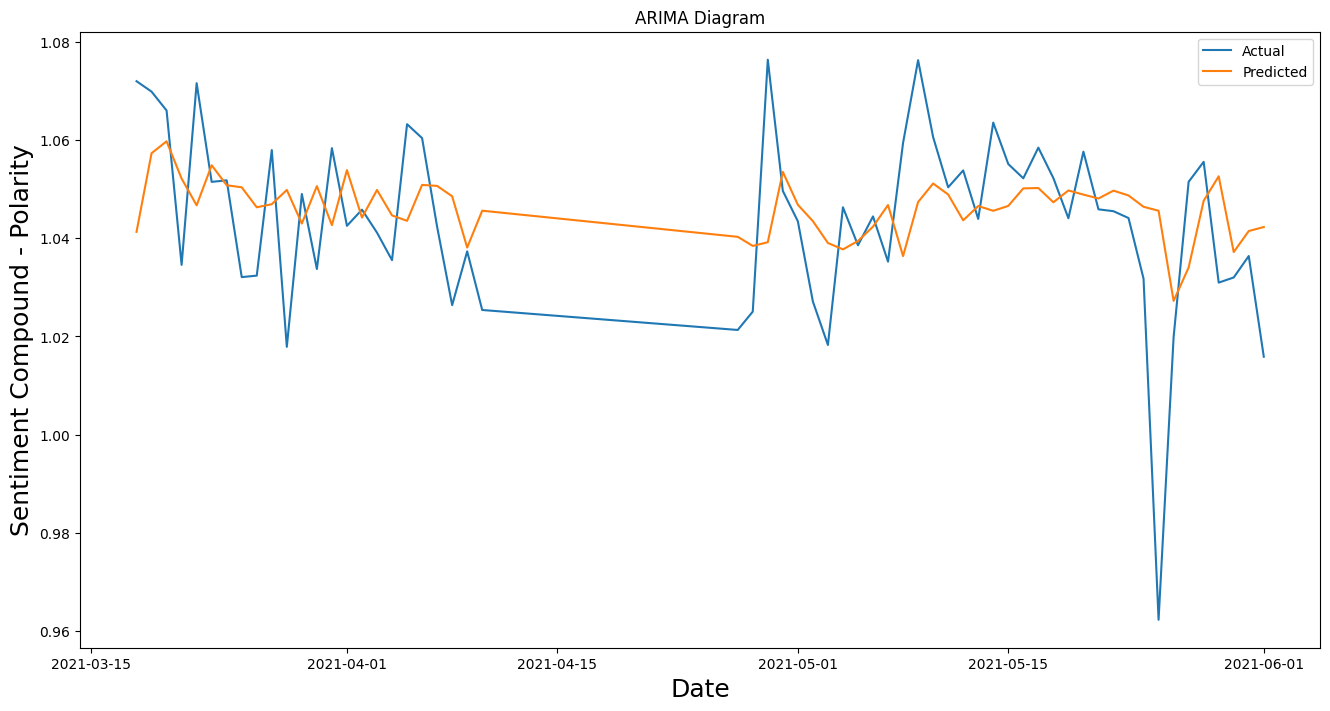

In [38]:
# Plot test and prediction
plt.figure(figsize=(16,8))
plt.plot(test_sc.index, test_sc.values, label='Actual')
plt.plot(test_sc.index, predictions, label='Predicted')
plt.legend()
plt.xlabel('Date',fontsize=18)
plt.ylabel('Sentiment Compound - Polarity', fontsize=18)
plt.title('ARIMA Diagram')
plt.show()

In [39]:
# Create the model
model1 = ARIMA(train_sc.values, order=(10, 2, 10))
model_fit = model1.fit()

C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
# Make prediction
predictions = model_fit.predict(start=len(train_sc), end=len(train_sc) + len(test_sc) - 1, typ='levels')

# Calcuate rmse
rmse = np.sqrt(mean_squared_error(test_sc.values, predictions))
print(f'RMSE: {rmse}')

RMSE: 0.017979918123176147


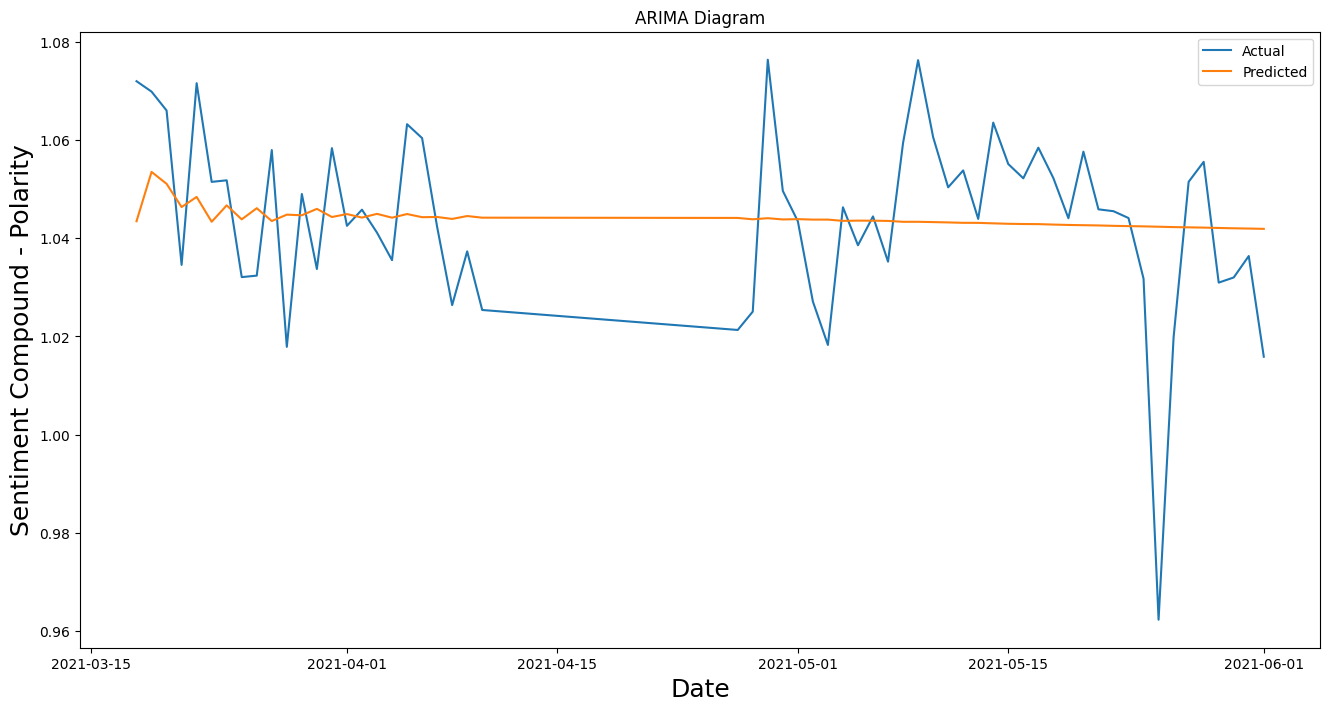

In [41]:
# Plot test and prediction
plt.figure(figsize=(16,8))
plt.plot(test_sc.index, test_sc.values, label='Actual')
plt.plot(test_sc.index, predictions, label='Predicted')
plt.legend()
plt.xlabel('Date',fontsize=18)
plt.ylabel('Sentiment Compound - Polarity', fontsize=18)
plt.title('ARIMA Diagram')
plt.show()

### CNN with LSTM

In [42]:
# window size for CNN
window=28

data_sc = time_series_df.filter(['sentiment_compound'])
dataset = data_sc.values
x_train = []
y_train = []

train_dataset_size = int(len(data_sc) * 0.80)


# Train dataset
train_data = dataset[0:train_dataset_size , :]


for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i,0])
    y_train.append(train_data[i , 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))

In [43]:
# Model building

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MSE', 'MAE'])

In [44]:
# train the model
model.fit(x_train, y_train, batch_size = 84, epochs = 20)

Epoch 1/20
3/3 [==============================] - 2s 59ms/step - loss: 0.7327 - MSE: 0.7327 - MAE: 0.8288
Epoch 2/20
3/3 [==============================] - 0s 72ms/step - loss: 0.1215 - MSE: 0.1215 - MAE: 0.2784
Epoch 3/20
3/3 [==============================] - 0s 55ms/step - loss: 0.0884 - MSE: 0.0884 - MAE: 0.2299
Epoch 4/20
3/3 [==============================] - 0s 56ms/step - loss: 0.0775 - MSE: 0.0775 - MAE: 0.2353
Epoch 5/20
3/3 [==============================] - 0s 56ms/step - loss: 0.0839 - MSE: 0.0839 - MAE: 0.2566
Epoch 6/20
3/3 [==============================] - 0s 55ms/step - loss: 0.0509 - MSE: 0.0509 - MAE: 0.1841
Epoch 7/20
3/3 [==============================] - 0s 64ms/step - loss: 0.0551 - MSE: 0.0551 - MAE: 0.1865
Epoch 8/20
3/3 [==============================] - 0s 55ms/step - loss: 0.0429 - MSE: 0.0429 - MAE: 0.1623
Epoch 9/20
3/3 [==============================] - 0s 57ms/step - loss: 0.0353 - MSE: 0.0353 - MAE: 0.1499
Epoch 10/20
3/3 [=============================

In [45]:

# Creation of test data
test_data = dataset[train_dataset_size -window: , :]
x_test = []
y_test = []
y_test = dataset[train_dataset_size:, :]

for i in range(window,len(test_data)):
    x_test.append(test_data[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [46]:
# Prediction
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 0s 15ms/step


In [47]:
# Generate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2_value = r2_score(y_test, predictions)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  0.04421480279118673
R^2 Value:  -4.758320614633409


C:\Users\Mara\AppData\Local\Temp\ipykernel_27376\1168553502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


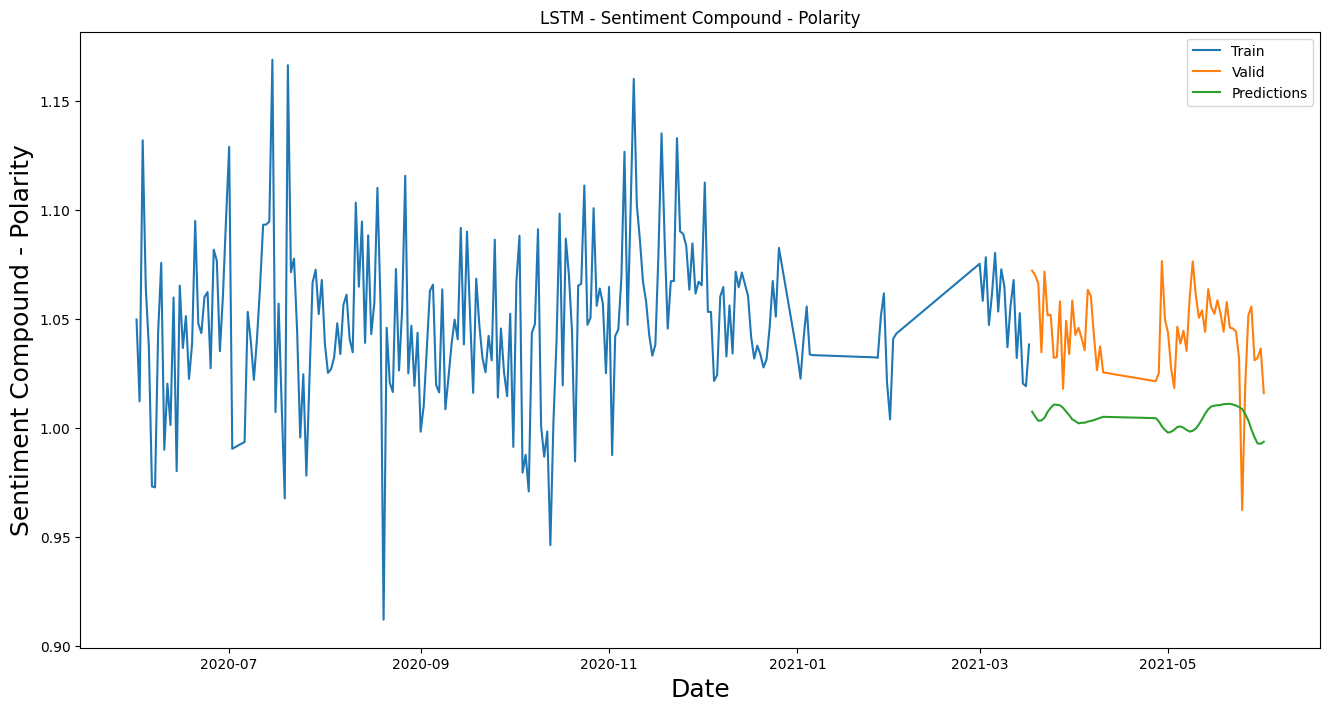

In [48]:
# Plot data
train = data_sc[:train_dataset_size]
valid = data_sc[train_dataset_size:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM - Sentiment Compound - Polarity')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Sentiment Compound - Polarity', fontsize=18)
plt.plot(train['sentiment_compound'])
plt.plot(valid[['sentiment_compound', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'])
plt.show()